In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import sklearn.metrics as metrics

In [2]:
class PCA:
  def __init__(self, data: pd.DataFrame, classes = pd.Series) -> None:
    self.__data = data
    self.__classes = classes  
    self.__eigval: np.ndarray = None
    self.__eigvec: np.ndarray = None
    self.__x_adj: pd.DataFrame = None
    self.__cov_adj: pd.DataFrame = None
    self.__sort_idx: np.ndarray = None
    self.__cal_pca()

  def __cal_pca(self):
    self.__x_adj = (self.__data - self.__data.mean()) 
    self.__cov_adj = self.__x_adj.cov()
    self.__eigval, self.__eigvec = np.linalg.eig(self.__cov_adj)
    self.__sort_idx = np.argsort(self.__eigval)[::-1]
    self.__eigvec = self.__eigvec.T

  def eigvec(self, n: int = None) -> np.ndarray:
    if n == None:
      return self.__eigvec
    
    return self.__eigvec[self.__sort_idx[:n]]
  
  def eigval(self, n: int = None) -> np.ndarray:
    if n == None:
      return self.__eigval

    return self.__eigval[self.__sort_idx[:n]]
  
  def project(self, n: int) -> pd.DataFrame:
    max_eigvec = self.eigvec(n)
    new_x = max_eigvec.dot(self.__x_adj.T).T
    new_x = pd.DataFrame(new_x)
    new_x.columns = [f"PC{i+1}" for i in range(n)]
    new_x["class"] = self.__classes
    return new_x
  
  def per_var_of(self, n: int) -> float:
    return self.eigval(n).sum() / self.eigval().sum()
  
  def eig_var(self) -> list[float]:
    sum_val = self.__eigval.sum()
    return [ e / sum_val for e in self.__eigval]
  
def add_class(data: pd.DataFrame, classes: pd.Series) -> pd.DataFrame:
  with_class = data.copy()
  with_class["class"] = classes
  return with_class

def plot_pca(data: pd.DataFrame, axises: list[str], labels=list, pointsize: int = 0.7, viewbox: list = None) -> None:
  p = None
  if len(axises) == 3:
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes(projection ="3d")
    if viewbox:
      ax.view_init(elev=viewbox[0], azim=viewbox[1], roll=viewbox[2])
    for l in labels:
      sc = data[data["class"] == l]
      ax.scatter3D(*[sc[axis] for axis in axises], s=pointsize,)
      ax.set_xlabel(axises[0])
      ax.set_ylabel(axises[1])
      ax.set_zlabel(axises[2])
  else:
    for l in labels:
      sc = data[data["class"] == l]
      plt.scatter(*[sc[axis] for axis in axises], s=pointsize,)
    plt.xlabel(axises[0])
    plt.ylabel(axises[1])
  plt.legend(labels)
  plt.show()

In [3]:
def kmean(X: np.ndarray, k, distance_fn, init_centers: np.ndarray = None, loops = 1000):
  old_centers = None
  if init_centers is None:
    old_centers = X[np.random.choice(X.shape[0], size=k, replace=False), :].copy()
  else:  
    old_centers = init_centers.copy()
  print(old_centers)
  old_lables = []
  for i in range(loops):
    new_labels = []
    for x in X:
      new_labels.append(np.argmin([distance_fn(x, c) for c in old_centers]))

    

    new_centers = np.zeros((k, X.shape[1]), dtype=float)
    count = np.zeros(k)
    for i, x in enumerate(X):
      new_centers[new_labels[i]] += x
      count[new_labels[i]] += 1

    for i, c in enumerate(new_centers):
      new_centers[i] /= count[i]

    if (old_centers == new_centers).all():
      old_centers = new_centers
      old_lables = new_labels
      break

    old_centers = new_centers
    old_lables = new_labels

  return np.array(old_lables), old_centers


In [4]:
def euclidean(x: np.ndarray, y: np.ndarray):
  return np.linalg.norm(x - y, 2, 0)

def manhattan(x: np.ndarray, y: np.ndarray):
  return np.linalg.norm(x - y, 1, 0)

In [5]:
X = np.array([
  [3, 0],
  [3.2, 0],
  [4, 0],
  [4, 4],
  [4.2, 4.2],
  [0, 4.2],
  [0, 4],
])

# Apply PCA and then Kmean for iris dataset

In [35]:
X = pd.read_csv("./iris/iris.data")
X.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
X_data = X[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values

In [37]:
pca = PCA(X[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']] , X['class'])

[[-0.92760343  0.74798588]
 [ 0.31278815  0.20943212]
 [-0.72660012  1.00517067]]


Text(0, 0.5, 'PC1')

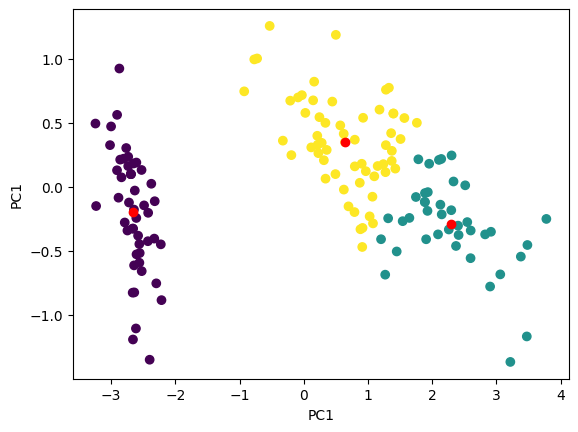

In [122]:
out = pca.project(2).drop(columns=["class"])
labels, centers = kmean(out.values, 3, euclidean)
plt.scatter(out.values[:,0], out.values[:,1], c=labels)
plt.scatter(centers[:,0], centers[:,1], c="red")
plt.xlabel("PC1")
plt.ylabel("PC1")

In [9]:
print("Silhouette Coefficient: %0.5f"% metrics.silhouette_score(pca.values, labels, metric='euclidean'))

Silhouette Coefficient: 0.59543


# Apply Kmean and then PCA for iris dataset

In [74]:
X = pd.read_csv("./iris/iris.data")
X.columns = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
X_data = X[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']].values

[[6.5 2.8 4.6 1.5]
 [5.7 3.8 1.7 0.3]
 [6.8 3.  5.5 2.1]]


Text(0, 0.5, 'PC2')

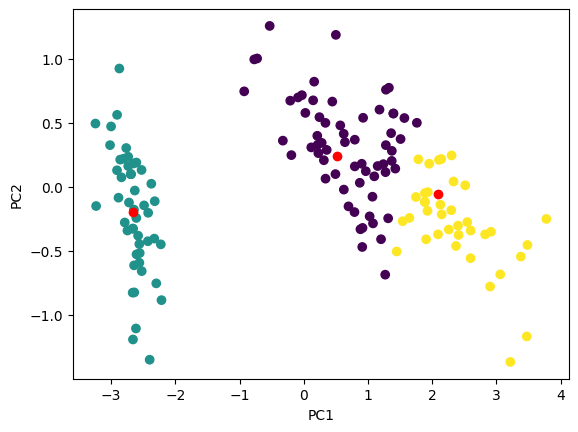

In [112]:
labels, centers = kmean(X_data, 3, manhattan)
pca = PCA(X[['sepal_length', 'sepal_width', 'petal_length', 'petal_width']] , X['class'])
pca_data = pca.project(2)
plt.scatter(pca_data.values[:,0], pca_data.values[:,1], c=labels)
plt.scatter(pca_data.groupby("class").mean()["PC1"], pca_data.groupby("class").mean()["PC2"], c='red')
plt.xlabel("PC1")
plt.ylabel("PC2")

# Apply PCA and then Kmean for rice dataset

In [12]:
X = pd.read_csv("./Rice_Cammeo_Osmancik.csv")
X.columns = ['area', 'perimeter', 'compactness', 'length', 'width', 'asymmetry', 'groove_length', 'class']
X_data = X[['area', 'perimeter', 'compactness', 'length', 'width', 'asymmetry', 'groove_length']].values

In [13]:
pca = PCA(X[['area', 'perimeter', 'compactness', 'length', 'width', 'asymmetry', 'groove_length']] , X['class'])

[[ 8.78225425e+02 -4.46469018e+01]
 [ 3.29630907e+03 -8.33215545e-01]]


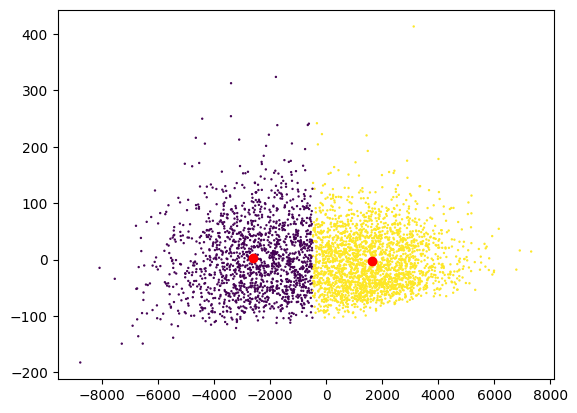

In [14]:
pca = pca.project(2).drop(columns=["class"])
labels, centers = kmean(pca.values, 2, euclidean)
plt.scatter(pca.values[:,0], pca.values[:,1], c=labels, s=0.5)
plt.scatter(centers[:,0], centers[:,1], c="red")

In [15]:
print("Silhouette Coefficient: %0.5f"% metrics.silhouette_score(pca.values, labels, metric='euclidean'))

Silhouette Coefficient: 0.60658


# Apply Kmean and then PCA for Rice dataset

In [16]:
X = pd.read_csv("./Rice_Cammeo_Osmancik.csv")
X.columns = ['area', 'perimeter', 'compactness', 'length', 'width', 'asymmetry', 'groove_length', 'class']
X_data = X[['area', 'perimeter', 'compactness', 'length', 'width', 'asymmetry', 'groove_length']].values

[[1.14370000e+04 4.30612000e+02 1.84134460e+02 7.92405396e+01
  9.02666569e-01 1.15870000e+04 6.87939823e-01]
 [1.21420000e+04 4.43515015e+02 1.77744751e+02 8.81975098e+01
  8.68206441e-01 1.24590000e+04 6.15626454e-01]]


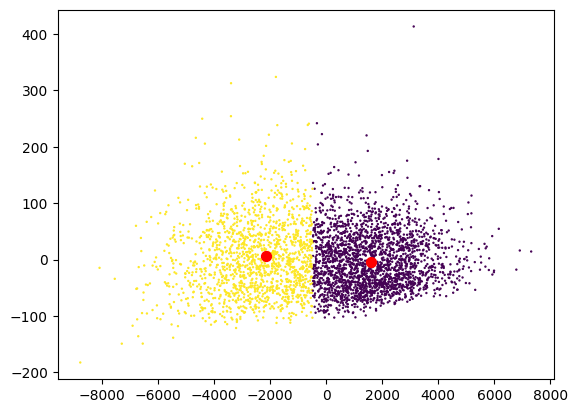

In [17]:
labels, centers = kmean(X_data, 2, euclidean)
pca = PCA(X[['area', 'perimeter', 'compactness', 'length', 'width', 'asymmetry', 'groove_length']] , X['class'])
# plot the centroids of pca
pca_data = pca.project(2)
plt.scatter(pca_data.values[:,0], pca_data.values[:,1], c=labels, s=0.5)
plt.scatter(pca_data.groupby("class").mean()["PC1"], pca_data.groupby("class").mean()["PC2"], c='red', s=50)

In [18]:
print("Silhouette Coefficient: %0.5f"% metrics.silhouette_score(pca_data.drop(columns=["class"]), labels, metric='euclidean'))

Silhouette Coefficient: 0.60658
